<a href="https://colab.research.google.com/github/engrvitalis/NAU/blob/main/ANN_Welding_Analysis4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading the needed *files*

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving welding_data_by_welding_types.csv to welding_data_by_welding_types.csv


Import relevant packages.

In [ ]:
"""Import the required modules"""
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Analyzing welding data by welding types

In [ ]:
df2 = pd.read_csv('welding_data_by_welding_types.csv')
df2 = pd.get_dummies(df2).drop('welding_type_SAW', axis=1)
df2 = df2[['current',	'voltage',	'welding_speed',	'plate_thickness',
           'welding_type_GMAW',	'welding_type_GTAW',	'welding_type_SMAW',
           'heat_input',	'tensile_strength',	'flexural_strength',	'hardness_value']]
df2.head()

,current,voltage,welding_speed,plate_thickness,welding_type_GMAW,welding_type_GTAW,welding_type_SMAW,heat_input,tensile_strength,flexural_strength,hardness_value
0,100,24,90,6,0,0,0,1600,435.0,320.1,164.0
1,100,28,120,8,0,0,0,1400,385.5,276.5,128.4
2,100,32,150,10,0,0,0,1280,370.2,272.8,116.2
3,130,24,120,10,0,0,0,1560,430.5,312.6,152.4
4,130,28,150,6,0,0,0,1456,390.6,293.2,130.2


Exploratory data analysis

	Current vs Response values


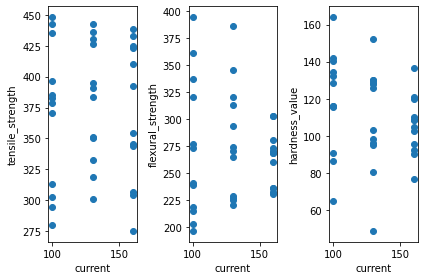



	Voltage vs Response values


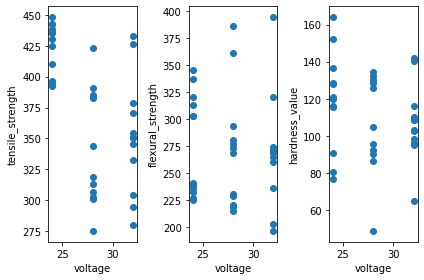



	Welding_speed vs Response values


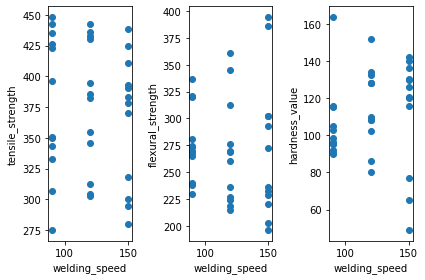



	Plate_thickness vs Response values


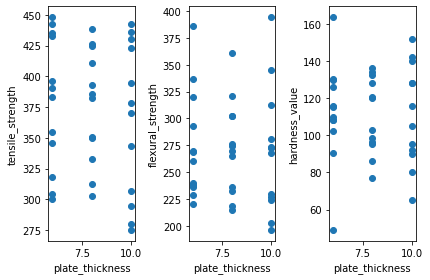

In [ ]:
pos = 1
for i in range(4):
  print(f'\t{df2.columns[i].capitalize()} vs Response values')
  plt.figure()
  for j in range(8, 11):
    plt.subplot(1, 3, pos)
    plt.scatter(df2.iloc[:, i], df2.iloc[:, j])
    plt.ylabel(df2.columns[j])
    plt.xlabel(df2.columns[i])
    pos += 1
  plt.tight_layout()
  plt.show()
  print('\n')
  pos = 1

Generate the necessary variables for modeling

In [ ]:
X1 = df2.iloc[:, :7]
X = X1.to_numpy()
y1 = df2.iloc[:, -4:]
y = y1.to_numpy()

Predicting individual response separately to optimize prediction

In [ ]:
for i in range(y.shape[1]):
  cols = y[:, i]
  X_train, X_test, y_train, y_test = train_test_split(X, cols,random_state=1, test_size=0.2)

  sc_X = StandardScaler()
  X_trainscaled=sc_X.fit_transform(X_train)
  X_testscaled=sc_X.transform(X_test)

  reg = MLPRegressor(hidden_layer_sizes=(30,30,30),activation="relu" ,random_state=1, max_iter=1000000).fit(X_trainscaled, y_train)

  y_pred=reg.predict(X_testscaled)
  print(f'R^2 for Response variable, {y1.columns[i].capitalize()}: {(r2_score(y_pred, y_test))}')

R^2 for Response variable, Heat_input: 0.9308444041949728
R^2 for Response variable, Tensile_strength: 0.48310968363758644
R^2 for Response variable, Flexural_strength: 0.29995245961273775
R^2 for Response variable, Hardness_value: 0.3970688531136587
